#I. Clone dữ liệu



In [ ]:
!pip install mne
!git clone https://github.com/YuDongPan/SSVEPNet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 64.0 MB/s eta 0:00:00
fatal: destination path 'SSVEPNet' already exists and is not an empty directory.


#II. Import thư viện

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.io import loadmat
from scipy.signal import butter, lfilter, filtfilt, iirnotch, find_peaks
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error,
                             accuracy_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cross_decomposition import CCA
from sklearn.neighbors import KNeighborsClassifier
from mne import create_info
import mne.io as io

#III. Tiền xử lý dữ liệu

## 1. Tổng hợp dữ liệu

In [ ]:
targets = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]
all_datas = []
all_labels = []

In [ ]:
# Tổng hợp từ 10 file lại
for i in range(10):
    datasub = loadmat(f'./SSVEPNet/data/Dial/DataSub_{i + 1}.mat')
    data = datasub['Data']
    labsub = loadmat(f'./SSVEPNet/data/Dial/LabSub_{i + 1}.mat')
    label = labsub['Label']
    for j in range(180):
        all_datas.append(data[:,:,j])
        all_labels.append(label[j])


In [ ]:
all_labels = [label.item() -1 for label in all_labels]

##2. Biểu đồ EEG

In [ ]:
def show_eeg(all_datas, idx):
    global all_labels
    global targets
    sfreq = 256
    ch_names = ['Pz', 'PO3', 'PO4', 'O1', 'O2', 'Oz', 'POz', 'Fz']
    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    raw_trial = io.RawArray(all_datas[idx], info)
    label = all_labels[idx]

    title = f"EEG Plot of Frequency: {targets[label]}"

    print(title)
    raw_trial.plot(duration=4, scalings=20)

def find_top_peaks(signal, fs=256, num_peaks=3, time_steps = 1024, min_height = 1e-3):
    # Tính toán FFT
    frequencies = np.fft.fftfreq(time_steps, d=1/fs)
    positive_frequencies = frequencies[:time_steps // 2]
    fft_result = np.fft.fft(signal)
    power_spectrum = np.abs(fft_result[:time_steps // 2])**2

    peaks, properties = find_peaks(power_spectrum, height=min_height)
    peak_frequencies = frequencies[peaks]
    peak_heights = properties['peak_heights']

    # Sắp xếp và lấy num_peaks đỉnh lớn nhất
    if len(peak_heights) > 0:
        sorted_indices = np.argsort(peak_heights)[-num_peaks:][::-1]
        top_frequencies = peak_frequencies[sorted_indices]
        top_heights = peak_heights[sorted_indices]
    else:
        top_frequencies = []
        top_heights = []

    return top_frequencies, top_heights

def show_fft(all_datas, idx):
    global all_labels
    global targets
    fs = 256
    time_steps = 1024
    channels = 8

    signal = all_datas[idx]
    frequencies = np.fft.fftfreq(time_steps, d=1/fs)
    positive_frequencies = frequencies[:time_steps // 2]

    plt.figure(figsize=(12, 12))
    title = f"FFT Plot of Frequency: {targets[all_labels[idx]]}"
    print(title)

    for i in range(channels):
        channel_data = signal[i, :]
        fft_result = np.fft.fft(channel_data)
        power_spectrum = np.abs(fft_result[:time_steps // 2])**2

        # Tìm các đỉnh
        peaks, properties = find_peaks(power_spectrum, height=1e-3)
        peak_frequencies = positive_frequencies[peaks]
        peak_heights = properties['peak_heights']

        # Lấy 3 đỉnh lớn nhất
        if len(peak_heights) > 0:
            sorted_indices = np.argsort(peak_heights)[-3:][::-1]  # Lấy 3 đỉnh lớn nhất
            top_frequencies = peak_frequencies[sorted_indices]
            top_heights = peak_heights[sorted_indices]
        else:
            top_frequencies = []
            top_heights = []

        # In thông tin đỉnh lớn nhất
        print(f"Channel {i + 1}:")
        for j, (freq, height) in enumerate(zip(top_frequencies, top_heights), start=1):
            print(f"  Peak {j}: Frequency = {freq:.2f} Hz, Power = {height:.4f}")

        # Vẽ phổ FFT và đánh dấu 3 đỉnh lớn nhất
        plt.subplot(4, 2, i + 1)
        plt.plot(positive_frequencies, power_spectrum, label="Power Spectrum")
        if len(top_frequencies) > 0:
            plt.scatter(top_frequencies, top_heights, color='red', label="Top 3 Peaks")
        plt.xlim(0, 100)
        plt.title(f"Channel {i + 1} - Frequency Spectrum")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power")
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

Creating RawArray with float64 data, n_channels=8, n_times=1024
    Range : 0 ... 1023 =      0.000 ...     3.996 secs
Ready.
EEG Plot of Frequency: 11.25


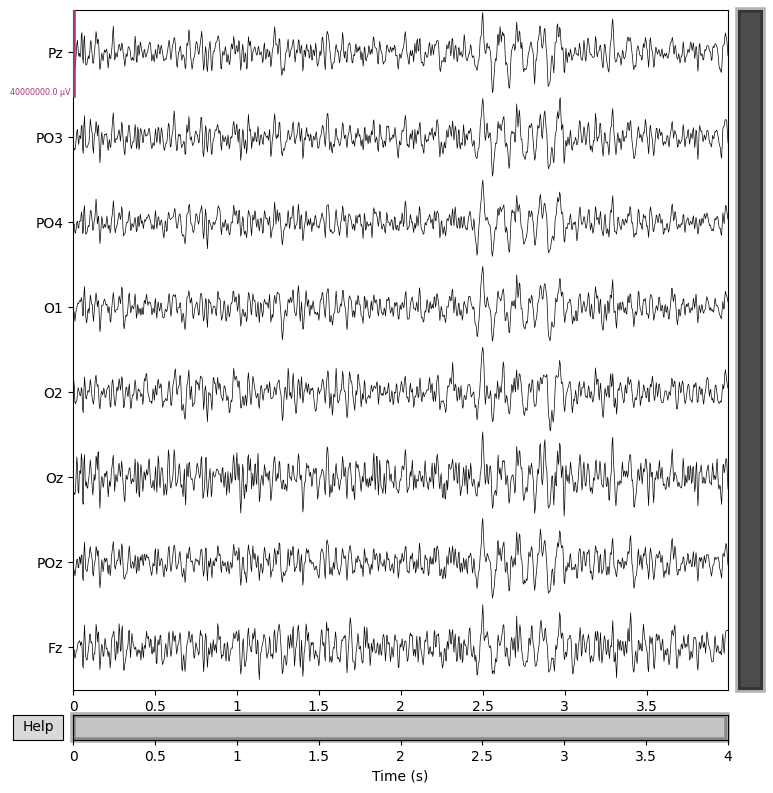

In [ ]:
show_eeg(all_datas, 24)

FFT Plot of Frequency: 11.25
Channel 1:
  Peak 1: Frequency = 9.25 Hz, Power = 503415.1688
  Peak 2: Frequency = 10.25 Hz, Power = 429959.9374
  Peak 3: Frequency = 11.50 Hz, Power = 429940.7475
Channel 2:
  Peak 1: Frequency = 10.50 Hz, Power = 630446.5303
  Peak 2: Frequency = 11.50 Hz, Power = 418373.8862
  Peak 3: Frequency = 9.25 Hz, Power = 281743.7206
Channel 3:
  Peak 1: Frequency = 10.50 Hz, Power = 618509.8052
  Peak 2: Frequency = 11.50 Hz, Power = 342643.5828
  Peak 3: Frequency = 8.00 Hz, Power = 293846.2162
Channel 4:
  Peak 1: Frequency = 10.50 Hz, Power = 563596.7699
  Peak 2: Frequency = 11.25 Hz, Power = 358814.2219
  Peak 3: Frequency = 12.75 Hz, Power = 326453.2011
Channel 5:
  Peak 1: Frequency = 9.00 Hz, Power = 513802.3044
  Peak 2: Frequency = 10.50 Hz, Power = 464051.5763
  Peak 3: Frequency = 12.75 Hz, Power = 445800.3256
Channel 6:
  Peak 1: Frequency = 10.50 Hz, Power = 675865.2849
  Peak 2: Frequency = 21.25 Hz, Power = 359737.4144
  Peak 3: Frequency = 12.

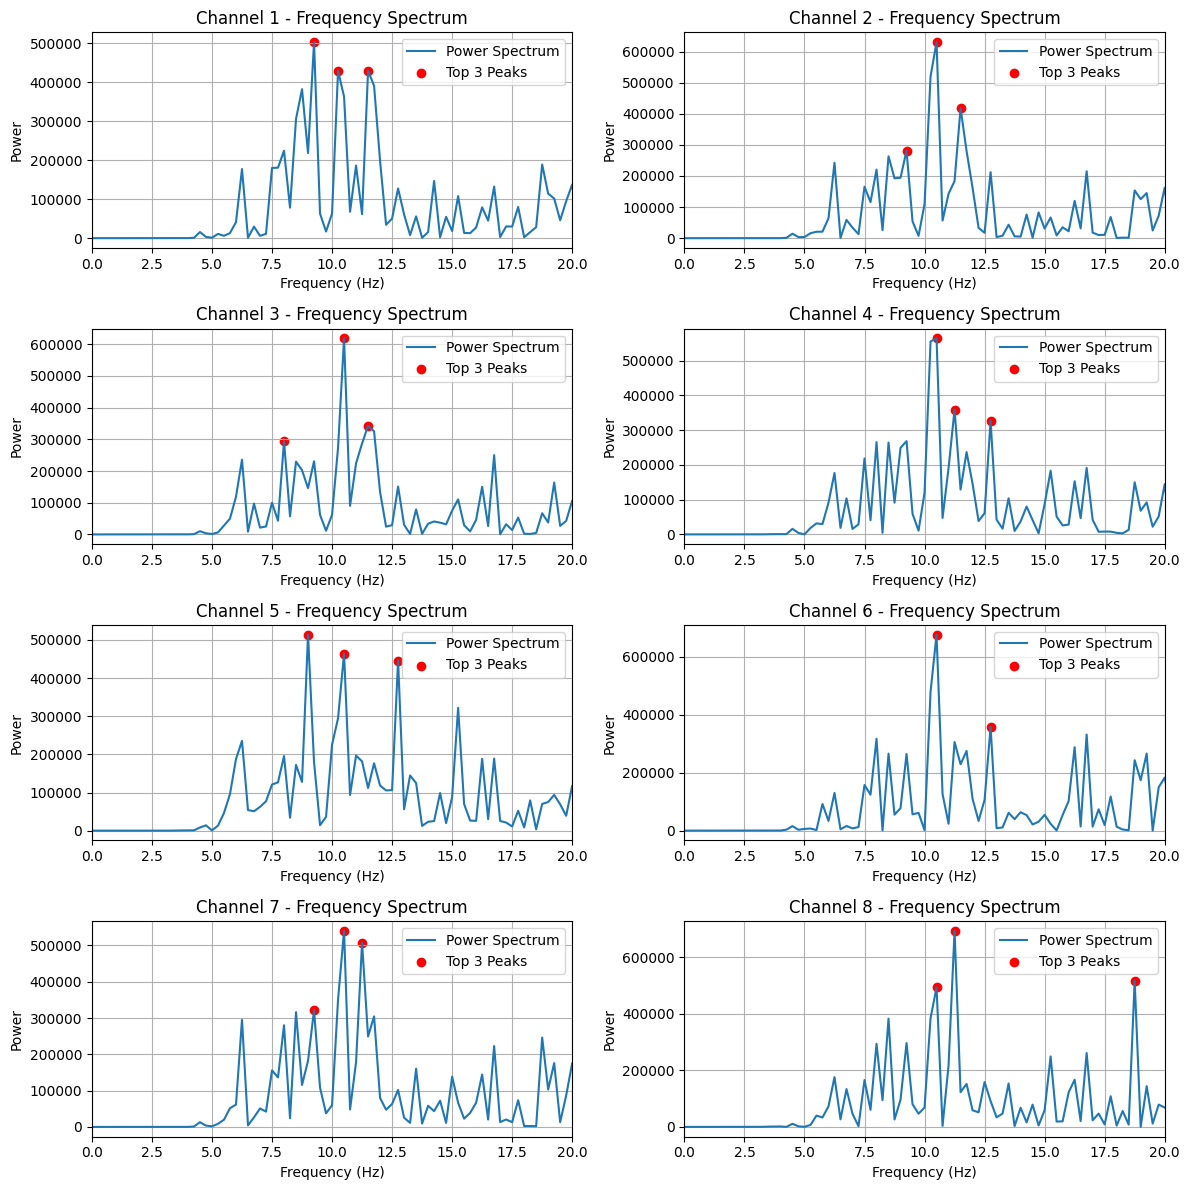

In [ ]:
show_fft(all_datas, 24)

##3. Sử dụng bộ lọc để loại bỏ nhiễu ngoài tần số quan tâm

In [ ]:
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

# Hàm tạo bộ lọc notch
def notch_filter(data, notch_freq, fs, quality_factor=30):
    b, a = iirnotch(notch_freq, quality_factor, fs)
    return lfilter(b, a, data)

# Pipeline lọc
def preprocess_eeg(data, fs, lowcut, highcut, notch_freqs, notch_quality=30):
    """
    Kết hợp Bandpass và Notch Filter.
    - lowcut, highcut: Dải tần số lọc.
    - notch_freqs: Các tần số nhiễu cần loại bỏ (50Hz, 60Hz, v.v.).
    - fs: Tần số lấy mẫu.
    """
    # Bước 1: Lọc nhiễu tại tần số notch
    data = notch_filter(data, notch_freqs, fs, quality_factor=notch_quality)
    # Bước 2: Lọc bandpass
    data = bandpass_filter(data, lowcut, highcut, fs)
    return data

# Thông số lọc
fs = 256  # Tần số lấy mẫu (Hz)
lowcut = 0.5
highcut = 50
notch_freq = 50
notch_quality = 30


In [ ]:
all_datas_filtered = [preprocess_eeg(d, fs, lowcut, highcut, notch_freq, notch_quality) for d in all_datas]

Creating RawArray with float64 data, n_channels=8, n_times=1024
    Range : 0 ... 1023 =      0.000 ...     3.996 secs
Ready.
EEG Plot of Frequency: 11.25


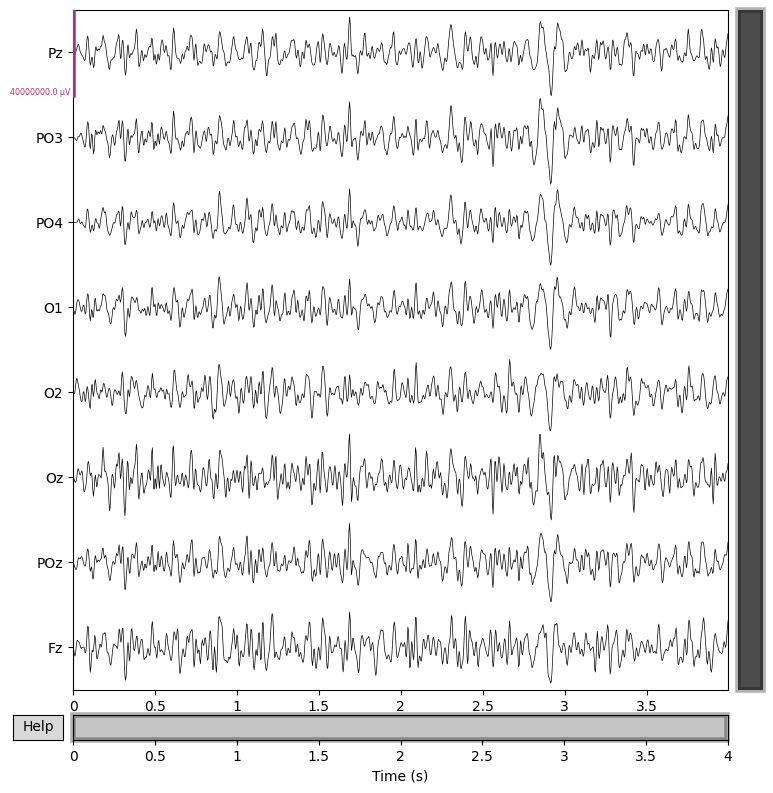

In [ ]:
# Biểu diễn tần số sau khi lọc nhiễu
show_eeg(all_datas_filtered, 25)

FFT Plot of Frequency: 11.25
Channel 1:
  Peak 1: Frequency = 9.25 Hz, Power = 507473.8155
  Peak 2: Frequency = 11.50 Hz, Power = 430619.2759
  Peak 3: Frequency = 10.25 Hz, Power = 426522.1215
Channel 2:
  Peak 1: Frequency = 10.50 Hz, Power = 634640.6662
  Peak 2: Frequency = 11.50 Hz, Power = 421232.2186
  Peak 3: Frequency = 9.25 Hz, Power = 285287.9718
Channel 3:
  Peak 1: Frequency = 10.50 Hz, Power = 626141.7777
  Peak 2: Frequency = 11.50 Hz, Power = 339931.2802
  Peak 3: Frequency = 8.00 Hz, Power = 288297.1204
Channel 4:
  Peak 1: Frequency = 10.50 Hz, Power = 571292.4549
  Peak 2: Frequency = 11.25 Hz, Power = 360549.8566
  Peak 3: Frequency = 12.75 Hz, Power = 323402.5755
Channel 5:
  Peak 1: Frequency = 9.00 Hz, Power = 508551.8875
  Peak 2: Frequency = 10.50 Hz, Power = 469922.1565
  Peak 3: Frequency = 12.75 Hz, Power = 441958.1570
Channel 6:
  Peak 1: Frequency = 10.50 Hz, Power = 675614.1207
  Peak 2: Frequency = 21.25 Hz, Power = 365508.6176
  Peak 3: Frequency = 12.

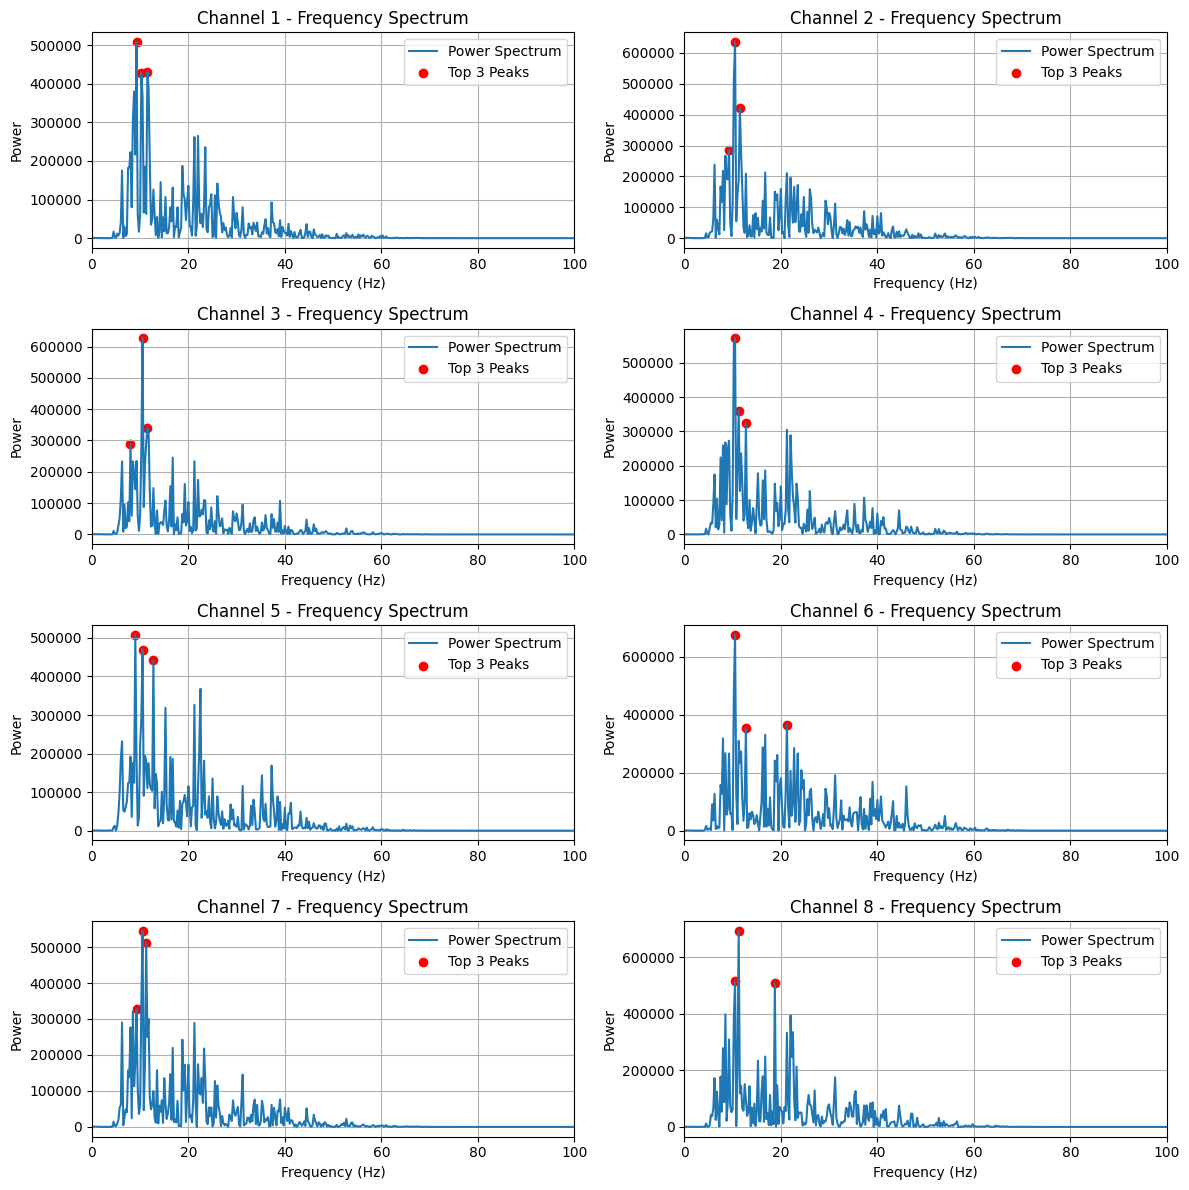

In [ ]:
#Phổ của tần số sau khi lọc nhiễu
show_fft(all_datas_filtered, 24)

##4. Đưa dữ liệu thành dạng bảng để dễ xử lý

In [ ]:
rows = []

# Lặp qua từng thử nghiệm
for i in range(len(all_datas_filtered)):
    trial = all_datas_filtered[i]  # Dữ liệu thử nghiệm thứ i
    label = all_labels[i]  # Nhãn của thử nghiệm này

    # Lặp qua từng kênh EEG
    for ch in range(trial.shape[0]):
        channel_data = trial[ch]  # Dữ liệu kênh thứ ch
        freqs, powers = find_top_peaks(channel_data)  # Lấy 3 đỉnh tần số và công suất

        # Lưu kết quả vào danh sách
        rows.append({
            "Trial": i + 1,  # Số thử nghiệm
            "Channel": ch + 1,  # Số kênh
            "Freq1": freqs[0],
            "Power1": powers[0],
            "Freq2": freqs[1],
            "Power2": powers[1],
            "Freq3": freqs[2],
            "Power3": powers[2],
            "Label": targets[label] # Nhãn tần số kích thích
        })

df = pd.DataFrame(rows)

print(df)

       Trial  Channel  Freq1        Power1  Freq2         Power2  Freq3  \
0          1        1   9.00  5.339453e+05  12.00  496161.225963   8.00   
1          1        2   9.00  5.664159e+05  12.00  491540.224344   8.00   
2          1        3   9.00  5.374962e+05   8.00  292977.829803  12.00   
3          1        4   9.00  1.378350e+06  18.25  503432.667540  15.50   
4          1        5   9.00  1.102368e+06  18.25  919348.233919  11.25   
...      ...      ...    ...           ...    ...            ...    ...   
14395   1800        4  14.75  1.285137e+06  15.75  501050.803309  13.00   
14396   1800        5  14.75  6.494856e+05  15.75  518044.200397   7.25   
14397   1800        6  14.75  5.619542e+05  15.25  482393.597461   7.25   
14398   1800        7  14.75  1.440969e+06  15.75  462909.775531  15.25   
14399   1800        8  14.75  9.831905e+05  15.25  427088.336778  13.00   

              Power3  Label  
0      350987.108062   9.25  
1      303209.513592   9.25  
2      27

In [ ]:
def Nomalization(df):
    # Bỏ qua cảnh báo
    warnings.filterwarnings("ignore")
    # One-hot encoding cho cột Channel
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_channel = encoder.fit_transform(df[['Channel']])
    encoded_channel_df = pd.DataFrame(encoded_channel, columns=encoder.get_feature_names_out(['Channel']))
    df = df.drop('Channel', axis=1)
    df = pd.concat([df, encoded_channel_df], axis=1)

    # Chuẩn hóa cột Power1, Power2, Power3 (Standardization)
    scaler = StandardScaler()
    power_cols = ['Power1', 'Power2', 'Power3']
    df[power_cols] = scaler.fit_transform(df[power_cols])

    # Mã hóa cột Label
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    return df

In [ ]:
df = Nomalization(df)

#IV. Lập mô hình

In [ ]:
def CCA_KNN(df, test_size=0.2):
    X = df.drop('Label', axis=1)
    y = df['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

    # Chuẩn hóa cột Power1, Power2, Power3 (Standardization)
    scaler = StandardScaler()
    power_cols = ['Power1', 'Power2', 'Power3']
    df[power_cols] = scaler.fit_transform(df[power_cols])

    # Mã hóa cột Label
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])

    # Chia dữ liệu thành train/test (80/20)
    X = df.drop('Label', axis=1)
    y = df['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Canonical Correlation Analysis (CCA)
    cca = CCA(n_components=1)  # Giảm số chiều xuống 1
    X_train_cca, y_train_cca = cca.fit_transform(X_train, pd.get_dummies(y_train))
    X_test_cca, y_test_cca = cca.transform(X_test, pd.get_dummies(y_test))

    # Chuyển đổi các giá trị dự đoán của CCA về dạng phân loại ban đầu
    # Sử dụng KNN để tìm label gần nhất
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(y_train_cca, y_train)
    y_pred_cca = knn.predict(y_test_cca)

    print("\nCCA Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_cca)}")
    print(classification_report(y_test, y_pred_cca))
    print(confusion_matrix(y_test, y_pred_cca))

In [ ]:
CCA_KNN(df, test_size=0.9)


CCA Results:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       1.00      1.00      1.00       233
           2       1.00      1.00      1.00       225
           3       1.00      1.00      1.00       260
           4       1.00      1.00      1.00       215
           5       1.00      1.00      1.00       244
           6       1.00      1.00      1.00       216
           7       1.00      1.00      1.00       225
           8       1.00      1.00      1.00       240
           9       1.00      1.00      1.00       230
          10       1.00      1.00      1.00       253
          11       1.00      1.00      1.00       257

    accuracy                           1.00      2880
   macro avg       1.00      1.00      1.00      2880
weighted avg       1.00      1.00      1.00      2880

[[282   0   0   0   0   0   0   0   0   0   0   0]
 [  0 233   0   0   0   0   0   0   0   0   0   0]
 [ 

In [ ]:
def cross_validation(df):
    X = df.drop('Label', axis=1)
    y = df['Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Khởi tạo KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Lưu trữ kết quả cross-validation
    cv_results = []

    fold_num = 1
    for train_index, val_index in kf.split(X):
        print(f"Fold {fold_num}:")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Khởi tạo và huấn luyện CCA trên tập train của fold này
        cca = CCA(n_components=1)
        X_train_cca, y_train_cca = cca.fit_transform(X_train, pd.get_dummies(y_train))

        # Áp dụng transform cho tập validation dựa trên CCA đã huấn luyện
        X_val_cca, y_val_cca = cca.transform(X_val, pd.get_dummies(y_val))

        # Sử dụng KNN để chuyển đổi đầu ra của CCA về dạng phân loại
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(y_train_cca, y_train)
        y_pred_cca = knn.predict(y_val_cca)

        # Đánh giá mô hình trên tập validation
        accuracy = accuracy_score(y_val, y_pred_cca)
        report = classification_report(y_val, y_pred_cca)
        cm = confusion_matrix(y_val, y_pred_cca)

        # Lưu kết quả vào cv_results
        cv_results.append({
            "fold": fold_num,
            "accuracy": accuracy,
            "classification_report": report,
            "confusion_matrix": cm
        })

        print(f"  Accuracy: {accuracy}")

        fold_num += 1

    # Tính trung bình accuracy từ các fold
    avg_accuracy = np.mean([result["accuracy"] for result in cv_results])
    print(f"\nAverage Cross-Validation Accuracy: {avg_accuracy}")

In [ ]:
cross_validation(df)

Fold 1:
  Accuracy: 1.0
Fold 2:
  Accuracy: 1.0
Fold 3:
  Accuracy: 1.0
Fold 4:
  Accuracy: 1.0
Fold 5:
  Accuracy: 1.0

Average Cross-Validation Accuracy: 1.0


# Test voi bo du lieu ben ngoai

In [ ]:
S1 = loadmat('s5.mat')

In [ ]:
S1

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Jul 31 12:59:55 2015',
 '__version__': '1.0',
 '__globals__': [],
 'ans': array([[  12,   18, 1114,   15]], dtype=uint16),
 'train': array([[[[ 6089.0625 ,  6950.375  ,  7567.40625, ...,  5708.6875 ,
            5591.84375,  5283.25   ],
          [ 6084.90625,  6957.28125,  7559.71875, ...,  5696.15625,
            5584.09375,  5282.375  ],
          [ 6087.75   ,  6963.8125 ,  7559.84375, ...,  5697.25   ,
            5574.53125,  5279.96875],
          ...,
          [ 6045.375  ,  6894.5    ,  7364.03125, ...,  5672.4375 ,
            5568.125  ,  5248.78125],
          [ 6043.21875,  6894.625  ,  7367.96875, ...,  5667.46875,
            5564.90625,  5252.96875],
          [ 6041.71875,  6902.1875 ,  7357.78125, ...,  5669.5    ,
            5564.21875,  5244.21875]],
 
         [[ 7414.40625,  7969.4375 ,  8307.5625 , ...,  4913.28125,
            4615.28125,  3727.75   ],
          [ 7423.15625,  7977.34375

In [ ]:
rows2 = []

# Lặp qua từng thử nghiệm
for i in range(len(all_datas_filtered)):
    trial = all_datas_filtered[i]  # Dữ liệu thử nghiệm thứ i
    label = all_labels[i]  # Nhãn của thử nghiệm này

    # Lặp qua từng kênh EEG
    for ch in range(trial.shape[0]):
        channel_data = trial[ch]  # Dữ liệu kênh thứ ch
        freqs, powers = find_top_peaks(channel_data)  # Lấy 3 đỉnh tần số và công suất

        # Lưu kết quả vào danh sách
        rows2.append({
            "Trial": i + 1,  # Số thử nghiệm
            "Channel": ch + 1,  # Số kênh
            "Freq1": freqs[0],
            "Power1": powers[0],
            "Freq2": freqs[1],
            "Power2": powers[1],
            "Freq3": freqs[2],
            "Power3": powers[2],
            "Label": targets[label] # Nhãn tần số kích thích
        })

# Tạo DataFrame từ danh sách
df2 = pd.DataFrame(rows2)

# Xem kết quả
print(df2)

       Trial  Channel  Freq1        Power1  Freq2         Power2  Freq3  \
0          1        1   9.00  5.339453e+05  12.00  496161.225963   8.00   
1          1        2   9.00  5.664159e+05  12.00  491540.224344   8.00   
2          1        3   9.00  5.374962e+05   8.00  292977.829803  12.00   
3          1        4   9.00  1.378350e+06  18.25  503432.667540  15.50   
4          1        5   9.00  1.102368e+06  18.25  919348.233919  11.25   
...      ...      ...    ...           ...    ...            ...    ...   
14395   1800        4  14.75  1.285137e+06  15.75  501050.803309  13.00   
14396   1800        5  14.75  6.494856e+05  15.75  518044.200397   7.25   
14397   1800        6  14.75  5.619542e+05  15.25  482393.597461   7.25   
14398   1800        7  14.75  1.440969e+06  15.75  462909.775531  15.25   
14399   1800        8  14.75  9.831905e+05  15.25  427088.336778  13.00   

              Power3  Label  
0      350987.108062   9.25  
1      303209.513592   9.25  
2      27

In [ ]:
df2 = Nomalization(df2)

In [ ]:
CCA_KNN(df2, test_size=0.9)


CCA Results:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       282
           1       1.00      1.00      1.00       233
           2       1.00      1.00      1.00       225
           3       1.00      1.00      1.00       260
           4       1.00      1.00      1.00       215
           5       1.00      1.00      1.00       244
           6       1.00      1.00      1.00       216
           7       1.00      1.00      1.00       225
           8       1.00      1.00      1.00       240
           9       1.00      1.00      1.00       230
          10       1.00      1.00      1.00       253
          11       1.00      1.00      1.00       257

    accuracy                           1.00      2880
   macro avg       1.00      1.00      1.00      2880
weighted avg       1.00      1.00      1.00      2880

[[282   0   0   0   0   0   0   0   0   0   0   0]
 [  0 233   0   0   0   0   0   0   0   0   0   0]
 [ 